---
title: "Kafka PySpark Example"
date: 2021-02-24
type: technical_note
draft: false
---

# Producing and Consuming Messages to/from Kafka and plotting, using python producer and spark consumer

To run this notebook you must already have created a Kafka topic 

## Imports

We use utility functions from the hops library to make Kafka configuration simple

Dependencies: 

- hops-py-util
- confluent-kafka

In [1]:
from hops import kafka
from hops import tls
from hops import hdfs
from confluent_kafka import Producer, Consumer
import numpy as np
from pyspark.sql.types import StructType, StructField, FloatType, TimestampType

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
34,application_1538483294796_0037,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


## Constants

Update the `TOPIC_NAME` field to reflect the name of your Kafka topic that you want to read/write from/to
Update the `OUTPUT_PATH` field to where the output data should be written

In [2]:
TOPIC_NAME = "test"
OUTPUT_PATH = "/Projects/" + hdfs.project_name() + "/Resources/data-csv"
CHECKPOINT_PATH = "/Projects/" + hdfs.project_name() + "/Resources/checkpoint-csv"

## Produce some Messages to the Topic

Specify the configuration, using hops-py-util

In [3]:
config = {
    "bootstrap.servers": kafka.get_broker_endpoints(),
    "security.protocol": kafka.get_security_protocol(),
    "ssl.ca.location": tls.get_ca_chain_location(),
    "ssl.certificate.location": tls.get_client_certificate_location(),
    "ssl.key.location": tls.get_client_key_location(),
    "group.id": "something"
}

Create producer with kafka-confluent API

In [4]:
producer = Producer(config)

producer.produce is an asychronous call so we create a callback to be notified when messages are delivered

In [5]:
def delivery_callback(err, msg):
    """
    Optional per-message delivery callback (triggered by poll() or flush())
    when a message has been successfully delivered or permanently
    failed delivery (after retries).
    """
    if err:
        print("Message failed delivery: {}".format(err))
    else:
        print('Message: {} delivered to topic: {}, partition: {}, offset: {}, timestamp: {}'.format(msg.value(), msg.topic(), msg.partition(), msg.offset(), msg.timestamp()))

Produce 100 random number-messages to the topic

In [15]:
normal_rnd_dist = np.random.normal(0, 0.1, 100)
for i in range(0, 100):
    producer.produce(TOPIC_NAME, str(normal_rnd_dist[i]), "key", callback=delivery_callback)
    
# Trigger the sending of all messages to the brokers, 20sec timeout
producer.flush(20) 

Message: -0.113515966706715 delivered to topic: test, partition: 1, offset: 450, timestamp: (1, 1538570713617L)
Message: -0.13372629136129505 delivered to topic: test, partition: 1, offset: 451, timestamp: (1, 1538570713617L)
Message: -0.030109530115267787 delivered to topic: test, partition: 1, offset: 452, timestamp: (1, 1538570713617L)
Message: 0.09914600908518259 delivered to topic: test, partition: 1, offset: 453, timestamp: (1, 1538570713617L)
Message: -0.13942848544599754 delivered to topic: test, partition: 1, offset: 454, timestamp: (1, 1538570713617L)
Message: 0.06244323355006787 delivered to topic: test, partition: 1, offset: 455, timestamp: (1, 1538570713617L)
Message: 0.12423451639758504 delivered to topic: test, partition: 1, offset: 456, timestamp: (1, 1538570713617L)
Message: 0.01979165601399879 delivered to topic: test, partition: 1, offset: 457, timestamp: (1, 1538570713617L)
Message: 0.13896608728374968 delivered to topic: test, partition: 1, offset: 458, timestamp: 

## Consume the Kafka Topic using Spark and Write to a Sink

The below snippet creates a streaming DataFrame with Kafka as a data source. Spark is lazy so it will not start streaming the data from Kafka into the dataframe until we specify an output sink (which we do later on in this notebook)

In [7]:
#lazy
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kafka.get_broker_endpoints()) \
  .option("kafka.security.protocol",kafka.get_security_protocol()) \
  .option("kafka.ssl.truststore.location", tls.get_trust_store()) \
  .option("kafka.ssl.truststore.password", tls.get_key_store_pwd()) \
  .option("kafka.ssl.keystore.location", tls.get_key_store()) \
  .option("kafka.ssl.keystore.password", tls.get_key_store_pwd()) \
  .option("kafka.ssl.key.password", tls.get_trust_store_pwd()) \
  .option("kafka.ssl.endpoint.identification.algorithm", "") \
  .option("subscribe", TOPIC_NAME) \
  .load()

When using Kafka as a data source, Spark gives us a default kafka schema as printed below

In [8]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

We are using the Spark structured streaming engine, which means that we can express stream queries just as we would do in batch jobs. 

Below we filter the input stream to select only the message values and their timestamp

In [12]:
messages = df.selectExpr("CAST(value AS STRING)", "timestamp").selectExpr("CAST(value AS FLOAT)", "timestamp")

Specify the output query and the sink of the stream job to be a CSV file in HopsFS. 

By using checkpointing and a WAL, spark gives us end-to-end exactly-once fault-tolerance

In [16]:
query = messages \
       .writeStream \
       .format("csv") \
       .option("path", OUTPUT_PATH) \
       .option("checkpointLocation", CHECKPOINT_PATH) \
       .start()

Run the streaming job, in theory streaming jobs should run forever.

However for this notebook example we are just going to read for 10 seconds and dump the output to the sink CSV file

In [17]:
query.awaitTermination(timeout=20) # 20 seconds timeout
query.stop()

<p style="color:red">
Sometimes there is a delay before the spark job starts writing to the sink, </p>

<p style="color:red">before going on to the next step in this notebook, go to your HDFS `OUTPUT_PATH` 
and verify that the csv output is not empty.</p>

<p style="color:red">If it is empty, re-run the query above</p>

## Read the Data from the Sink

In [19]:
schema = StructType([
    StructField("value", FloatType(), True),
    StructField("timestamp", TimestampType(), True)])

df1 = spark.read \
     .format("csv") \
     .option("header", "false") \
     .schema(schema) \
     .load(OUTPUT_PATH)

In [20]:
df1.printSchema()

root
 |-- value: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)

## Visualize the DataFrame using SparkMagic

<p style="color:red">This visualization currenly only works in Python 2.*</p>

This command copies the spark dataframe from the cluster 
to the local machine and converts it to a pandas dataframe named "df1". 
This pandas dataframe is available in all cells started with the sparkmagic: %%local and can be used for 
visualizations and plotting.

In [24]:
%%spark -o df1

Below is sparkmagics default plotting

In [26]:
%%local
df1

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11J1R5cGU6JyksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1RhYmxlJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzcwcHgnKSzigKY=


Output()

Install matplotlib on the local machine in case it is not already installed

In [ ]:
%%bash
pip install --user matplotlib

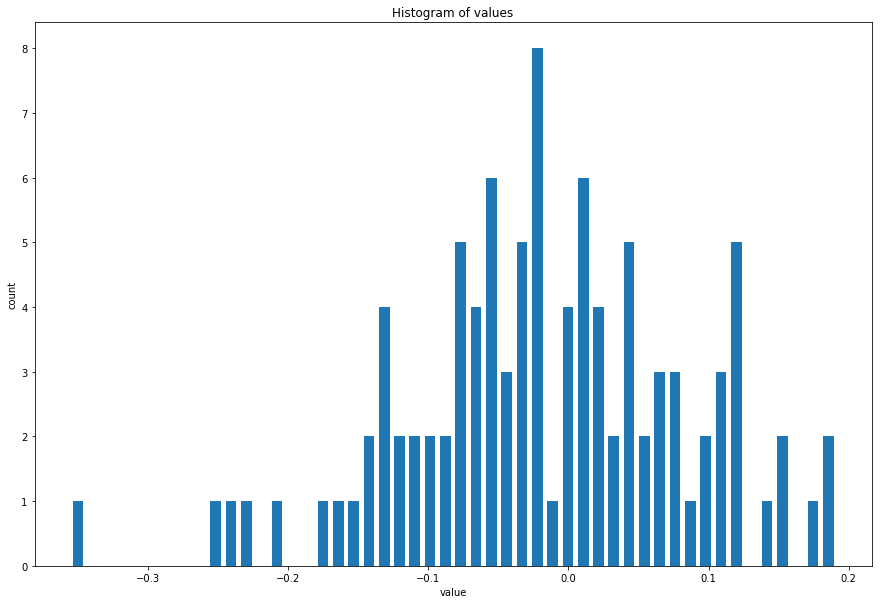

In [39]:
%%local
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
hist, bins = np.histogram(df1["value"], bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Histogram of values")
plt.xlabel("value")
plt.ylabel("count")
plt.show()